# Reproduction of grokking on a conv net for image classification

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [116]:
# Imports
import os
import datetime
import random
import glob
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Create dataset

In [124]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_frac=0.3, number_occurence=100, device='cpu'):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """

    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, int(train_frac*number_occurence)))
    val_idx = np.zeros((10, number_occurence - int(train_frac*number_occurence)))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, number_occurence)
        
        train_idx[number], val_idx[number] = train_test_split(random_selection, train_size=train_frac, random_state=seed)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx.flatten().astype(int)][:, None, :, :].double().to(device)
    Y_train = dataset.targets[train_idx.flatten().astype(int)].long().to(device)
    X_val = dataset.data[val_idx.flatten().astype(int)][:, None, :, :].double().to(device)
    Y_val = dataset.targets[val_idx.flatten().astype(int)].long().to(device)
    return X_train, Y_train, X_val, Y_val

# Step 2: Define model

In [125]:
# Default network architecture
img_size = 28
n_channels = 1
num_classes = 10

# Conv layers
num_filters = np.array([4])
filter_sizes = np.array([5])
pool_sizes = np.array([2])

# Fully connected layer
fc_layers = np.array([64])


class NumberDetector(nn.Module):
    def __init__(self, device='cpu', weight_noise=0):
        super(NumberDetector, self).__init__()
        self.device = device
        self.weight_noise = weight_noise
        
        
        # Add all conv layers in beginning
        self.conv_layers = []
        for i in range(num_filters.size):
            # Add conv
            if i == 0:
                self.conv_layers.append(nn.Conv2d(n_channels, num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))
            else:
                self.conv_layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))

            # Add pool
            if pool_sizes[i] > 1:
                self.conv_layers.append(torch.nn.MaxPool2d(kernel_size=(pool_sizes[i], pool_sizes[i])))

            # Add relu
            self.conv_layers.append(nn.ReLU())    
        
        self.conv_seq = nn.Sequential(*self.conv_layers)

        
        # Add fully connected layers
        # First layer
        self.lin_input_size = int(num_filters[-1] * ( img_size / np.prod(pool_sizes) )**2)
        self.lin_layers = [nn.Linear(self.lin_input_size, fc_layers[0]), nn.ReLU()]
        
        # Intermediate layers
        print(fc_layers.size)
        if fc_layers.size >= 2:
            for i in range(fc_layers.size-1):
                self.lin_layers.append(nn.Linear(fc_layers[i], fc_layers[i+1]))
                self.lin_layers.append(nn.ReLU())
    
        # Final layer
        self.lin_layers.append(nn.Linear(fc_layers[-1], num_classes))
        
        self.lin_seq = nn.Sequential(*self.lin_layers)

        
    def add_noise(self):
        with torch.no_grad():
            for layer in self.conv_seq:
                params = layer._parameters
                if 'weight' in params.keys():
                    w = params['weight']
                    noise = torch.randn(w.size())*self.weight_noise
                    params['weight'] = w + noise.to(self.device)
                    
            for layer in self.lin_seq:
                params = layer._parameters
                if 'weight' in params.keys():
                    w = params['weight']
                    noise = torch.randn(w.size())*self.weight_noise
                    params['weight'] = w + noise.to(self.device)

            
    def forward(self, x):
        # Conv layers
        x = self.conv_seq(x)

        # Fully connected layer
        x = x.view(-1, self.lin_input_size)
        x = self.lin_seq(x)

        return x

# Step 3: Training the model

In [126]:
def per_number_loss(predictions, labels, loss_fn):
    loss = np.zeros(10)
    for number in range(10):
        idx = np.where(labels.cpu()==number)
        number_pred = predictions[idx]
        number_label = labels[idx]
                
        loss[number] = loss_fn(number_pred, number_label)
    return loss
        
def kernel_ex_loss(X, y, model, loss_fn):
    pass

In [127]:
# Try to "turn off" a specific kernel (zero out)
def ex_loss(data, label, model, loss_fn):

    ex_loss = []
    
    for layer in model.conv_seq:
        ex_loss_layer = []
        
        if isinstance(layer, nn.Conv2d):
            for i in range(len(layer._parameters['weight'])):
                with torch.no_grad():
                    # Zero out weights
                    layer_backup = layer._parameters['weight'][i].clone().detach()
                    layer._parameters['weight'][i] = torch.DoubleTensor(np.zeros((1, 1, 5, 5)))
                    
                    # Calculate exclussion loss
                    pred = model(data)
                    loss = loss_fn(pred, label)
                    ex_loss_layer.append(loss)
                    
                    # Reset weights
                    layer._parameters['weight'][i] = layer_backup
            
            ex_loss.append(ex_loss_layer)
    
    return ex_loss

In [140]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector(device=device, weight_noise=weight_noise).double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Path already exists")
        
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_frac=train_frac, number_occurence=number_occurence, device=device)
    
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_number_losses = np.zeros((10, num_epochs))
    val_number_losses = np.zeros((10, num_epochs))
    
    train_ex_losses = []
    val_ex_losses = []
    
    # Train over several epochs
    for epoch in range(num_epochs):
        if weight_noise and epoch >= noise_after:
            model.add_noise()
        
        
        # Calculate train and val loss
        train_pred = model(X_train)
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses.append(train_loss.item())
        
        optimizer.zero_grad()
        train_loss.backward()
        
        
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses.append(val_loss.item())
    
        # Per number loss
        if calc_number_loss:
            train_number_losses[:, epoch] = per_number_loss(train_pred, Y_train, loss_fn)
            val_number_losses[:, epoch] = per_number_loss(val_pred, Y_val, loss_fn)
        
        # Exclussion loss
        if calc_kernel_ex_loss and (epoch%calc_ex_loss_every == 0):
            with torch.no_grad():
                train_ex_losses.append( ex_loss(X_train, Y_train, model, loss_fn) )
                val_ex_losses.append( ex_loss(X_val, Y_val, model, loss_fn) )
    
        
        # Print status
        if epoch%100 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

        # Calc gradients and perform backprop
        optimizer.step()

        if (save_models) and (epoch%save_every == 0):

            save_dict = {
                'model': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_number_losses': train_number_losses,
        'val_number_losses': val_number_losses,
        'train_ex_losses': train_ex_losses,
        'val_ex_losses': val_ex_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [148]:
# Random seeds for reproducability
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)

# Model params
lr=1e-3
weight_decay = 1
noise_after = 500
weight_noise = 0

# Training params
num_epochs = 30000
save_models = True
save_every = 1000
save_root = Path("checkpoints")

# Dataset params
train_frac = 0.4
number_occurence = 10

calc_kernel_ex_loss = True
calc_ex_loss_every = 200
calc_number_loss = True

# Run training
exp_name = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
exp_name = "test"
train(exp_name)

1
Path already exists
0_2.5646_2.4629
Saved model to checkpoints/test/0.pth
100_-8.3990_1.1865
200_-8.4506_0.9494
300_-8.8986_0.7642
400_-9.7872_0.6817
500_-11.0233_0.6710
600_-12.2420_0.6940
700_-13.5314_0.7950
800_-14.7795_0.9891
900_-15.9897_1.1499
1000_-17.1033_1.2448
Saved model to checkpoints/test/1000.pth
1100_-18.1588_1.3121
1200_-19.1259_1.3488
1300_-20.0190_1.3617
1400_-20.7942_1.3556
1500_-21.4855_1.3511
1600_-21.9990_1.3432
1700_-22.3294_1.3218
1800_-22.4814_1.2903
1900_-22.5152_1.2554
2000_-22.5014_1.2220
Saved model to checkpoints/test/2000.pth
2100_-22.4783_1.1901
2200_-22.4691_1.1495
2300_-22.4536_1.1081
2400_-22.4473_1.0821
2500_-22.4434_1.0612
2600_-22.4410_1.0439
2700_-22.4400_1.0292
2800_-22.4412_1.0161
2900_-22.4437_1.0048
3000_-22.4463_0.9958
Saved model to checkpoints/test/3000.pth
3100_-22.4492_0.9886
3200_-22.4535_0.9821
3300_-22.4582_0.9766
3400_-22.4617_0.9707
3500_-22.4690_0.9648
3600_-22.4715_0.9581
3700_-22.4736_0.9525
3800_-22.4770_0.9474
3900_-22.4796_0.

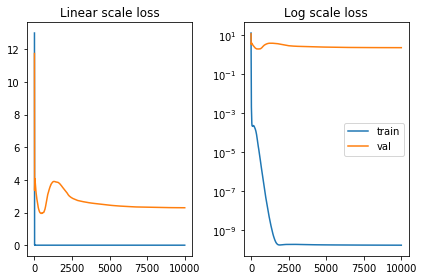

In [147]:
#Train versus val errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
fig, (ax0, ax1) = plt.subplots(1, 2)
   
ax0.set_title("Linear scale loss")
ax0.plot(load_dict['train_losses'], label='train')
ax0.plot(load_dict['val_losses'], label="val")

ax1.set_yscale('log')
ax1.set_title("Log scale loss")
ax1.plot(load_dict['train_losses'], label='train')
ax1.plot(load_dict['val_losses'], label="val")

plt.tight_layout()
plt.legend()

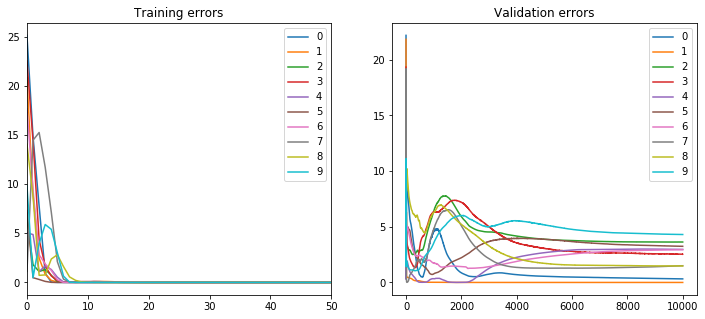

In [144]:
# Visualize per-number errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

fig, ax = plt.subplots(1, 2,  figsize=(12, 5))

for number, losses in enumerate(load_dict['train_number_losses']):
    ax[0].set_title("Training errors")
    ax[0].plot(losses, label=str(number))
    ax[0].legend()
    ax[0].set_xlim(0, 50)

    
for number, losses in enumerate(load_dict['val_number_losses']):
    ax[1].set_title("Validation errors")
    ax[1].plot(losses, label=str(number))
    ax[1].legend()

plt.show()

In [133]:
# Plot exclusion losses
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

train_ex_losses = load_dict['train_ex_losses']
train_losses = load_dict['train_losses']
val_ex_losses = load_dict['val_ex_losses']
val_losses = load_dict['val_losses']

n_layers = len(train_ex_losses[0])
timesteps = np.arange(0, num_epochs, calc_ex_loss_every)

fig, ax = plt.subplots(n_layers, 2, figsize=(12, 5*n_layers))

for layer_idx in range(n_layers):
    layer_ax = ax[layer_idx] if n_layers > 1 else ax
    # Allocate memory 
    num_kernels = len(train_ex_losses[0][layer_idx])
    layer_losses = np.zeros((2, num_kernels, timesteps.size))

    # Gather data for each time step
    for t in range(timesteps.size):
        layer_losses[0, :, t] = train_ex_losses[t][layer_idx]
        layer_losses[1, :, t] = val_ex_losses[t][layer_idx]
        
    # For each kernel, plot its corresponding graph
    for i in range(num_kernels):
        layer_ax[0].plot(timesteps, layer_losses[0, i, :],  label=f"Kernel {i+1}")
        layer_ax[1].plot(timesteps, layer_losses[1, i, :],  label=f"Kernel {i+1}")
    
    layer_ax[0].plot(timesteps, train_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[0].set_title("Train")
    
    layer_ax[1].plot(timesteps, val_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[1].set_title("Val")
    
    layer_ax[1].legend()
    layer_ax[0].set_ylabel(f"Layer {layer_idx+1}")


IndexError: list index out of range

0 0
1 500
2 1000
3 1500
4 2000
5 2500
6 3000
7 3500
8 4000
9 4500
10 5000


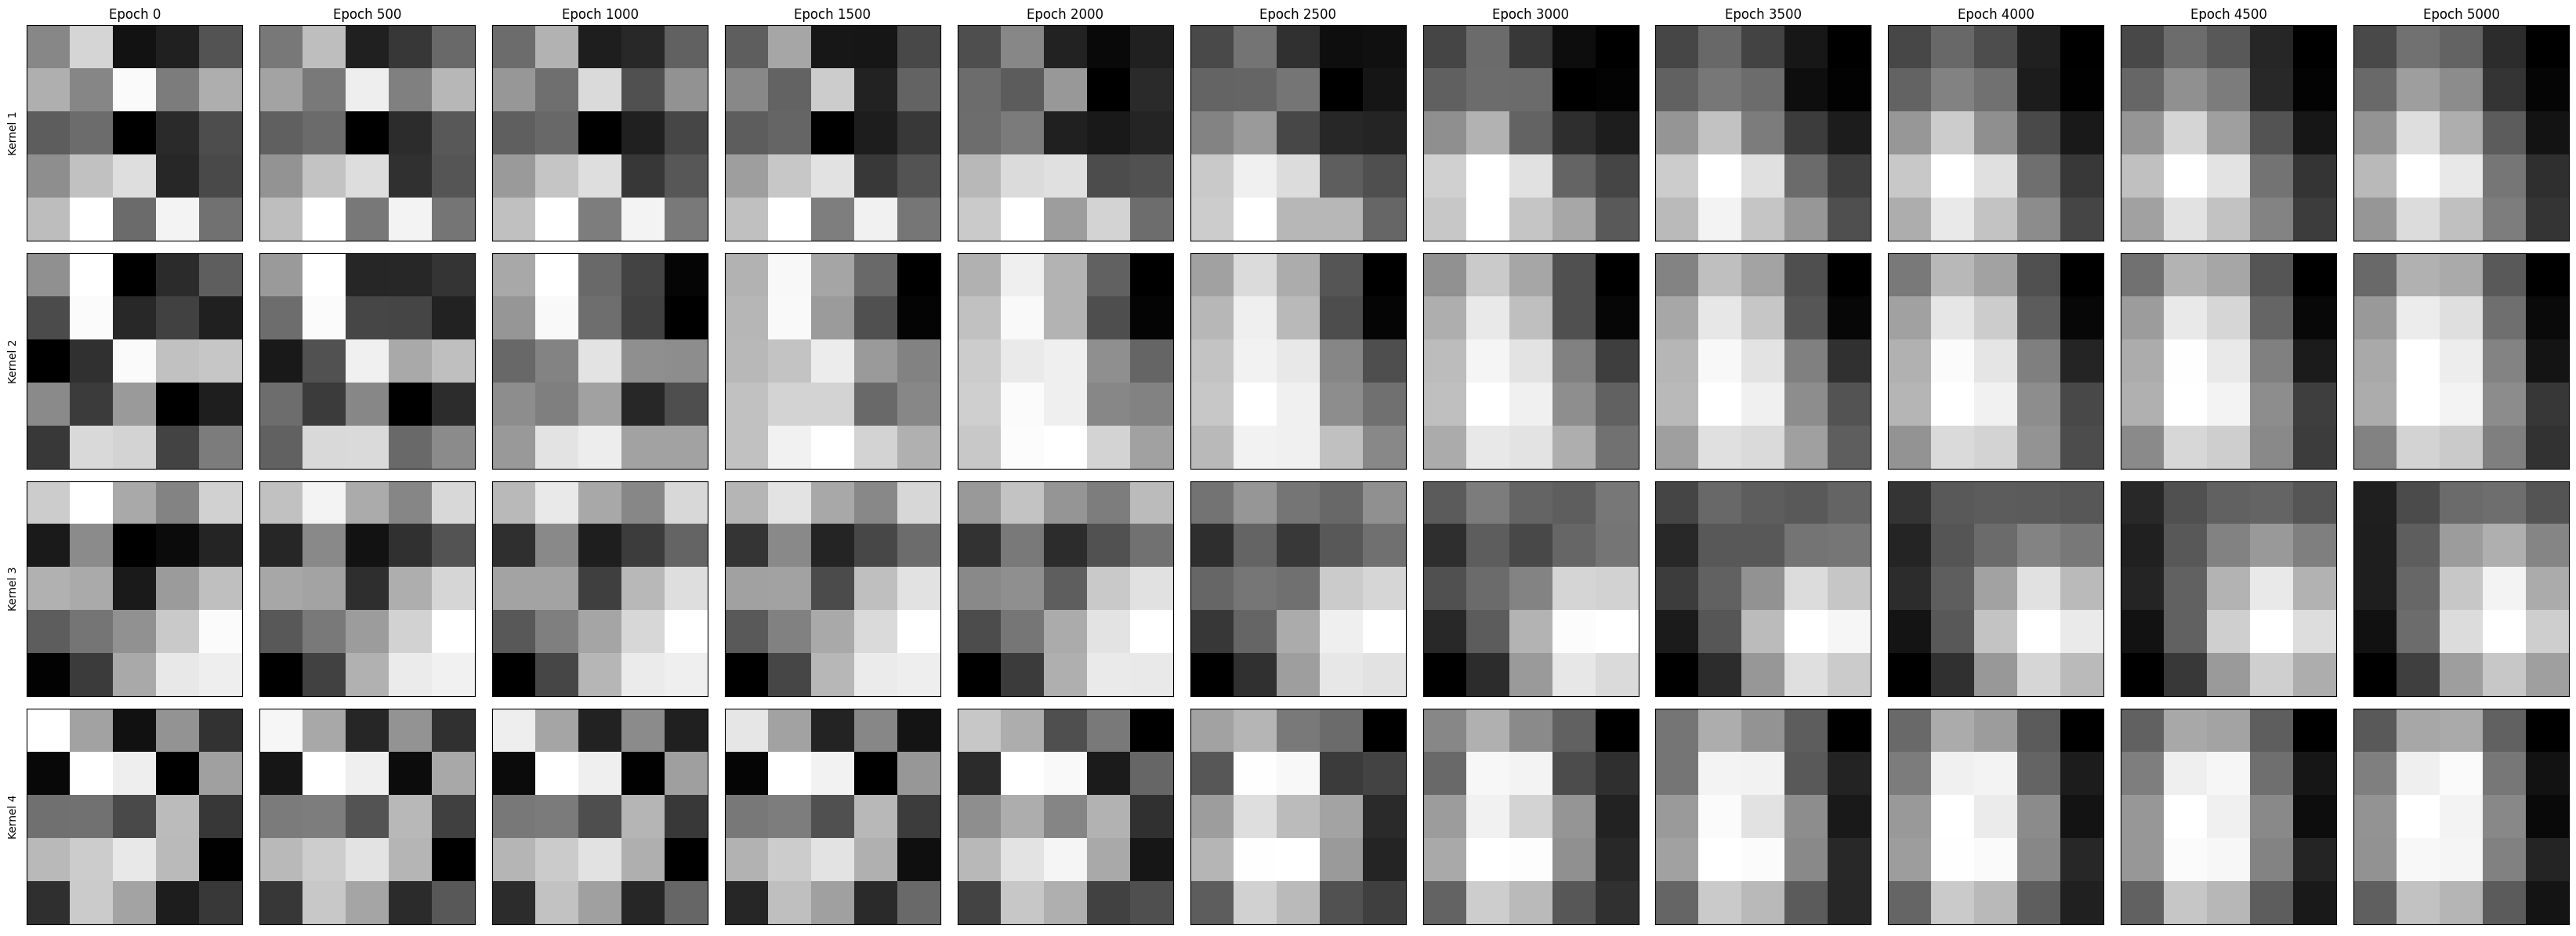

In [16]:
# Visualize kernels
def visualize_kernels(layer_num=1):
    cpts = glob.glob(f"checkpoints/{exp_name}/*")
    
    
    kernels = {}
    
    for cpt in cpts:
        if 'init' in cpt:
            continue
        elif 'final' in cpt:
            epoch = num_epochs
        else:
            epoch = int(os.path.basename(cpt).split(".")[0])
            
        load_dict = torch.load(cpt)
        
        kernels[epoch] = load_dict['model'][f'conv_seq.{layer_num-1}.weight']
        

    n_cols = len(list(kernels.items()))
    n_rows = len(list(kernels.items())[0][1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    
    for i, epoch in enumerate(sorted(kernels)):
        print(i, epoch)
        
        for j, kernel in enumerate(kernels[epoch].squeeze()):
            ax = axs[j][i] 

            # Layout
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(kernel.cpu(), cmap='gray')
        
            if i == 0:
                ax.set_ylabel(f"Kernel {j+1}")
            if j == 0:
                ax.set_title(f"Epoch {epoch}")
    plt.tight_layout()
        
visualize_kernels()